<a href="https://colab.research.google.com/github/TacticalCoders/NLP-with-Pytorch/blob/main/6_2_Classifying_Surnames_With_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문자 RNN으로 성씨 국적 분류하기

6.1에서는 단어를 기준으로 RNN을 설명했다. 즉, 단어가 특정 길이의 벡터를 가지는(단어 임베딩) 상황을 가정했다. 하지만 여기서는 문자가 기준이다. 

한 단어는 문자의 순서데이터이다. 따라서 RNN에 각 문자를 입력해주어 문자의 순서에 따른 패턴을 학습시킬 수 있다.

4장에서 실습했던 데이터셋(18개 국적의 성씨 10,000개)과 RNN을 활용하여 문자로 이루어진 성씨를 가지고 국적에 따라 분류하는 모델을 만들어보자.

## SurnameDataset


In [4]:
# 전처리된 데이터를 다운로드
!mkdir data
!wget https://git.io/JtSPf -O data/download.py
!wget https://git.io/JtSPU -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

--2022-07-14 06:33:15--  https://git.io/JtSPf
Resolving git.io (git.io)... 140.82.114.22
Connecting to git.io (git.io)|140.82.114.22|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_6/classifying-surnames/data/download.py [following]
--2022-07-14 06:33:15--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_6/classifying-surnames/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2022-07-14 06:33:15 (17.7 MB/s) - ‘data/download.py’ saved [1572/1572]

--2022-07-14 06:33:15--  https:/

In [6]:
# pandas로 csv 읽어오기
import pandas as pd
surnames = pd.read_csv("data/surnames/surnames.csv", header=0)
surnames.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [9]:
set(surnames.nationality) # 고유 속성(국적 보기)

{'Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese'}

In [10]:
# 최종적으로 사용할 데이터(훈련/검증/테스트로 구문)
surnames_final = pd.read_csv("data/surnames/surnames_with_splits.csv", header=0)
surnames_final.head()

,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh


## 성씨 국적 분류 RNN 모델 만들기


### Vocabulary

In [11]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [12]:
class Vocabulary(object):
    """매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 """

    def __init__(self, token_to_idx=None):
        """
        매개변수:
            token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다 """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다 """
        return cls(**contents)

    def add_token(self, token):
        """ 토큰을 기반으로 매핑 딕셔너리를 업데이트합니다

        매개변수:
            token (str): Vocabulary에 추가할 토큰
        반환값:
            index (int): 토큰에 상응하는 정수
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """토큰 리스트를 Vocabulary에 추가합니다.
        
        매개변수:
            tokens (list): 문자열 토큰 리스트
        반환값:
            indices (list): 토큰 리스트에 상응되는 인덱스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """토큰에 대응하는 인덱스를 추출합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다.
        
        매개변수: 
            index (int): 찾을 인덱스
        반환값:
            token (str): 인텍스에 해당하는 토큰
        에러:
            KeyError: 인덱스가 Vocabulary에 없을 때 발생합니다.
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [13]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """ 토큰에 대응하는 인덱스를 추출합니다.
        토큰이 없으면 UNK 인덱스를 반환합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면 (Vocabulary에 추가하기 위해)
            `unk_index`가 0보다 커야 합니다.
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

voacbulary 클래스가 말뭉치에 등장하는 단어를 인덱스로 매핑한다면 SequenceVocalbulary는 특수토큰을 순서대로 add_token 해준다. (순서대로 0,1,2,3 반환)
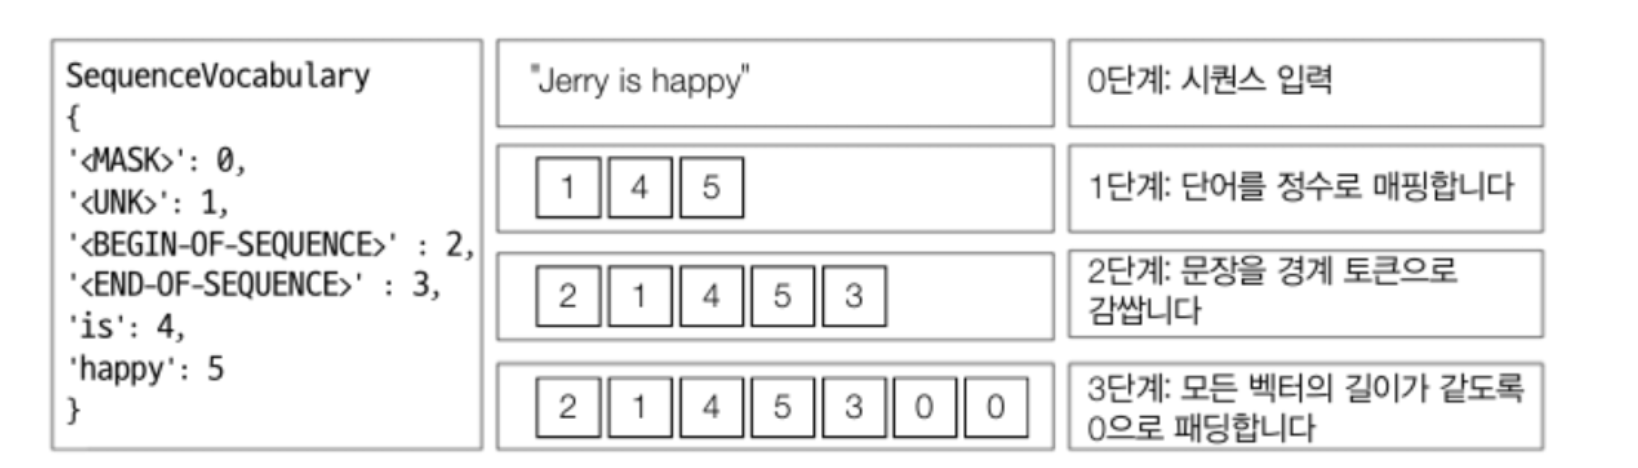

순차데이터를 다룰 때는 패딩에 사용할 mask(0), 어휘사전(vocabulary)에 없는 단어를 만났을 때는 unk(1), 문장의 시작과 끝은 bos(2)와 eos(3)의 특수 토큰이 필요하다. 따라서 이를 추가해준 것.

### Vectorizer

우선 성씨에 있는 각 문자 토큰을 고유한 정수에 매핑한다. (char_vocab, 'a'-3, 'b'-4,...)

그 다음 그 정수들을 벡터로 변환한다. 

이렇게 하면 각 문자별로, 순서별로, 벡터가 생성되고 이는 곧 3차원 텐서이다. 이것이 신경망의 입력으로 들어가게 된다.

In [14]:
class SurnameVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다 """
    def __init__(self, char_vocab, nationality_vocab):
        """
        매개변수:
            char_vocab (Vocabulary): 문자를 정수로 매핑합니다
            nationality_vocab (Vocabulary): 국적을 정수로 매핑합니다
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        매개변수:
            title (str): 문자열
            vector_length (int): 인덱스 벡터의 길이를 맞추기 위한 매개변수
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """데이터셋 데이터프레임으로 SurnameVectorizer 객체를 초기화합니다.
        
        매개변수:
            surname_df (pandas.DataFrame): 성씨 데이터셋
        반환값:
            SurnameVectorizer 객체
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'nationality_vocab': self.nationality_vocab.to_serializable()}

### Dataset

In [15]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        매개변수:
            surname_df (pandas.DataFrame): 데이터셋
            vectorizer (SurnameVectorizer): 데이터셋에서 만든 Vectorizer 객체
        """
        self.surname_df = surname_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # 클래스 가중치
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """데이터셋을 로드하고 새로운 Vectorizer 객체를 만듭니다
        
        매개변수:
            surname_csv (str): 데이터셋의 위치
        반환값:
            SurnameDataset의 객체
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """ 데이터셋과 새로운 Vectorizer 객체를 로드합니다.
        캐시된 Vectorizer 객체를 재사용할 때 사용합니다.
        
        매개변수:
            surname_csv (str): 데이터셋의 위치
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        반환값:
            SurnameDataset의 인스턴스
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """파일에서 Vectorizer 객체를 로드하는 정적 메서드
        
        매개변수:
            vectorizer_filepath (str): 직렬화된 Vectorizer 객체의 위치
        반환값:
            SurnameVectorizer의 인스턴스
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """Vectorizer 객체를 json 형태로 디스크에 저장합니다
        
        매개변수:
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다 """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """파이토치 데이터셋의 주요 진입 메서드
        
        매개변수:
            index (int): 데이터 포인트 인덱스
        반환값:
            다음 값을 담고 있는 딕셔너리:
                특성 (x_data)
                레이블 (y_target)
                특성 길이 (x_length)
        """
        row = self._target_df.iloc[index]
        
        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)
        
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector, 
                'y_target': nationality_index, 
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        """배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수를 반환합니다
        
        매개변수:
            batch_size (int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size

    

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    파이토치 DataLoader를 감싸고 있는 제너레이터 함수.
    걱 텐서를 지정된 장치로 이동합니다.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### 모델 : SurnameClassifier 

SurnameClassifier 모델은 임베딩 층과, ElmanRNN 층, Linear 층으로 구성된다.

임베딩 층이 있다는 것은 **정수를 벡터로 변환**한다는 뜻이고 이는 곳 모델의 **입력이 정수**라는 점이다.

앞서 각 문자를 정수로 매핑했는데, 이것이 벡터로 변환된다는 뜻이다.

그렇게 변환된 벡터를 가지고 RNN을 통해 시퀀스의 벡터 표현을 계산한다. 이 벡터는 성씨에 있는 각 문자에 대한 은닉 상태를 나타낸다. 

마지막에는 성씨에 마지막 문자에 해당하는 벡터를 추출한다.(이 벡터에는 앞선 문자의 정보들도 담겨있다.) 이 최종 벡터가 전체 시퀀스 입력을 거쳐 전달된 결과물, 즉 성씨를 '**요약**'한 벡터이다.

이 벡터를 Linear층으로 보내 예측 벡터(어느 국적인가에 대한)를 계산한다. 그리고 이 예측을 바탕으로 손실을 계산하거나 소프트 맥스 함수에 적용하여 성씨에 대한 확률 분포(18개의 국적)를 만든다.

In [17]:
def column_gather(y_out, x_lengths):
    ''' y_out에 있는 각 데이터 포인트에서 마지막 벡터를 추출합니다

    조금 더 구체적으로 말하면 배치 행 인덱스를 순회하면서
    x_lengths에 있는 값에 해당하는 인덱스 위치의 벡터를 반환합니다.

    매개변수:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    반환값:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class ElmanRNN(nn.Module):
    """ RNNCell을 사용하여 만든 엘만 RNN """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        매개변수:
            input_size (int): 입력 벡터 크기
            hidden_size (int): 은닉 상태 벡터 크기
            batch_first (bool): 0번째 차원이 배치인지 여부
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """ ElmanRNN의 정방향 계산
        
        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서 
                If self.batch_first: x_in.shape = (batch_size, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch_size, feat_size)
            initial_hidden (torch.Tensor): RNN의 초기 은닉 상태
        반환값:
            hiddens (torch.Tensor): 각 타임 스텝에서 RNN 출력
                If self.batch_first: 
                   hiddens.shape = (batch_size, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch_size, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens


class SurnameClassifier(nn.Module):
    """ RNN으로 특성을 추출하고 MLP로 분류하는 분류 모델 """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        매개변수:
            embedding_size (int): 문자 임베딩의 크기
            num_embeddings (int): 임베딩할 문자 개수
            num_classes (int): 예측 벡터의 크기
                노트: 국적 개수
            rnn_hidden_size (int): RNN의 은닉 상태 크기
            batch_first (bool): 입력 텐서의 0번째 차원이 배치인지 시퀀스인지 나타내는 플래그
            padding_idx (int): 텐서 패딩을 위한 인덱스; 
                torch.nn.Embedding을 참고하세요
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """ 분류기의 정방향 계산
        
        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서 
                x_in.shape는 (batch, input_dim)입니다
            x_lengths (torch.Tensor): 배치에 있는 각 시퀀스의 길이
                시퀀스의 마지막 벡터를 찾는데 사용합니다
            apply_softmax (bool): 소프트맥스 활성화 함수를 위한 플래그
                크로스-엔트로피 손실을 사용하려면 False로 지정합니다
        반환값:
            결과 텐서. tensor.shape는 (batch, output_dim)입니다.
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [16]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### 설정

In [18]:
args = Namespace(
    # 날짜와 경로 정보
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch6/surname_classification",
    # 모델 하이퍼파라미터
    char_embedding_size=100,
    rnn_hidden_size=64,
    # 훈련 하이퍼파라미터
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    early_stopping_criteria=5,
    # 실행 옵션
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("CUDA 사용여부: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

CUDA 사용여부: False


In [19]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # 체크포인트를 로드합니다.
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv, 
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

### 훈련

In [20]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """훈련 상태를 업데이트합니다.

    콤포넌트:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # 손실이 나빠지면
        if loss_t >= loss_tm1:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [21]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size), 
                               position=1, 
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size), 
                             position=1, 
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------
            
            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 단계 1. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("반복 중지")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

## 평가

In [22]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])
    
    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [23]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 1.7554078006744385;
테스트 정확도: 42.62499999999999


## 추론

In [24]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probability': prob_value, 'surname': surname}

In [26]:
classifier = classifier.to("cpu")

In [27]:
surname = input("성씨를 입력하세요:")
print(predict_nationality(surname, classifier, vectorizer))

성씨를 입력하세요:kang
{'nationality': 'Korean', 'probability': 0.5701490640640259, 'surname': 'kang'}


In [28]:
surname = input("성씨를 입력하세요:")
print(predict_nationality(surname, classifier, vectorizer))

성씨를 입력하세요:wang
{'nationality': 'Korean', 'probability': 0.3676953911781311, 'surname': 'wang'}


In [30]:
surname = input("성씨를 입력하세요:")
print(predict_nationality(surname, classifier, vectorizer))

성씨를 입력하세요:DiCaprio
{'nationality': 'Italian', 'probability': 0.4410761594772339, 'surname': 'DiCaprio'}
